<a href="https://www.kaggle.com/code/sanju182k01/deepfake-detection1?scriptVersionId=92425135" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepfake-detection-challenge/sample_submission.csv
/kaggle/input/deepfake-detection-challenge/test_videos/qooxnxqqjb.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/hierggamuo.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ocgdbrgmtq.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/icbsahlivv.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/prhmixykhr.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ihglzxzroo.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/yarpxfqejd.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/orixbcfvdz.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/qxyrtwozyw.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/hqzwudvhih.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ghnpsltzyn.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ziipxxchai.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/fddmkqjwsh.mp4
/kaggle/input/deepfake-de

!pip install dlib

In [2]:
!pip install dlib

     |████████████████████████████████| 7.4MB 908kB/s eta 0:00:01
  Created wheel for dlib: filename=dlib-19.23.1-cp36-cp36m-linux_x86_64.whl size=4325029 sha256=815a4ecbf1133ed890e7cb5bd496725e71d6ee0d75c933cad4f82d5d3bbfb6a0
  Stored in directory: /root/.cache/pip/wheels/65/fb/bb/7eb21f2c6c793083b413a0de7d45502860713cc5709f27039b
Successfully built dlib


In [3]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [4]:
os.mkdir('/kaggle/working/dataset')
os.mkdir('/kaggle/working/dataset/real')
os.mkdir('/kaggle/working/dataset/fake')

In [6]:
train_frame_folder = '/kaggle/input/deepfake-detection-challenge/train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/kaggle/working/dataset/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/kaggle/working/dataset/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                count+=1

In [7]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [9]:
input_shape = (128, 128, 3)
data_dir = '/kaggle/working/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
print(Y_train)

In [15]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model 
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

219062272/219055592 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [16]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Train on 2996 samples, validate on 749 samples
Epoch 1/20
2996/2996 [==============================] - 42s 14ms/sample - loss: 0.6063 - accuracy: 0.6849 - val_loss: 0.8708 - val_accuracy: 0.4700
Epoch 2/20
2996/2996 [==============================] - 12s 4ms/sample - loss: 0.4573 - accuracy: 0.8468 - val_loss: 0.7116 - val_accuracy: 0.5901
Epoch 3/20
2996/2996 [==============================] - 11s 4ms/sample - loss: 0.3574 - accuracy: 0.9115 - val_loss: 0.6247 - val_accuracy: 0.6836
Epoch 4/20
2996/2996 [==============================] - 11s 4ms/sample - loss: 0.2913 - accuracy: 0.9332 - val_loss: 0.5348 - val_accuracy: 0.7704
Epoch 5/20
2996/2996 [==============================] - 11s 4ms/sample - loss: 0.2263 - accuracy: 0.9516 - val_loss: 0.4847 - val_accuracy: 0.7984
Epoch 6/20
2996/2996 [==============================] - 11s 4ms/sample - loss: 0.1816 - accuracy: 0.9613 - val_loss: 0.4522 - val_accuracy: 0.8251
Epoch 7/20
2996/2996 [==============================] - 11s 4ms/sample

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

True positive =  2986
False positive =  0
False negative =  759
True negative =  0




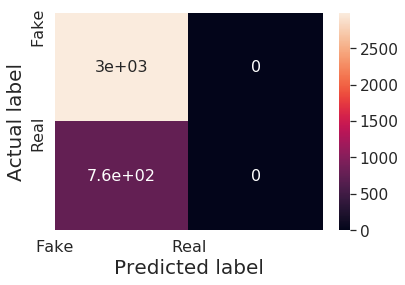

In [36]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, model.predict_classes(X))

In [ ]:
model.save('deepfake-detection-model.h5')

In [ ]:
import tensorflow as tf
import dlib
import cv2
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
tf.__version__

In [ ]:
model = load_model('deepfake-detection-model.h5')

In [ ]:
input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('../input/deepfake-detection-challenge/test_videos/jzmzdispyo.mp4')
frameRate = cap.get(5)
while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % ((int(frameRate)+1)*1) == 0:
        face_rects, scores, idx = detector.run(frame, 0)
        for i, d in enumerate(face_rects):
            x1 = d.left()
            y1 = d.top()
            x2 = d.right()
            y2 = d.bottom()
            crop_img = frame[y1:y2, x1:x2]
            data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
            data = data.reshape(-1, 128, 128, 3)
            print(model.predict_classes(data))

In [21]:
import sklearn.metrics
cm = sklearn.metrics.accuracy_score(Y_val_org, model.predict_classes(X))

In [22]:
print(cm)

0.9773030707610146


In [79]:
!pip install keras_efficientnets

from keras_efficientnets import EfficientNetB5

In [84]:
#Defining the model
base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=input_shape, classes=2)

#Adding the final layers to the above base models where the actual classification is done in the dense layers

model1= Sequential()
model1.add(base_model) 
model1.add(Flatten())

#Adding the Dense layers along with activation and batch normalization
model1.add(Dense(1024,activation=('relu'),input_dim=512))

model1.add(Dense(512,activation=('relu'))) 
model1.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))
model1.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model1.add(Dense(2,activation=('softmax')))
#Model summary
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 4, 4, 2048)        28513520  
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_79 (Dense)             (None, 1024)              33555456  
_________________________________________________________________
dense_80 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_81 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_82 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_83 (Dense)             (None, 2)                

In [86]:
batch_size= 200
epochs=15 
learn_rate=.001 
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False) 
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
model1.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [88]:
history = model1.fit(X_train,Y_train, batch_size = 100, epochs = 25, validation_data = (X_val,Y_val), verbose = 1)

Train on 2996 samples, validate on 749 samples
Epoch 1/25
2996/2996 [==============================] - 38s 13ms/step - loss: 0.5085 - accuracy: 0.7947 - val_loss: 0.5232 - val_accuracy: 0.7864
Epoch 2/25
2996/2996 [==============================] - 31s 10ms/step - loss: 0.3767 - accuracy: 0.8171 - val_loss: 0.5326 - val_accuracy: 0.7864
Epoch 3/25
2996/2996 [==============================] - 32s 11ms/step - loss: 0.2699 - accuracy: 0.8955 - val_loss: 0.5473 - val_accuracy: 0.7864
Epoch 4/25
2996/2996 [==============================] - 31s 10ms/step - loss: 0.1776 - accuracy: 0.9436 - val_loss: 0.5722 - val_accuracy: 0.7850
Epoch 5/25
2996/2996 [==============================] - 31s 10ms/step - loss: 0.0972 - accuracy: 0.9846 - val_loss: 0.6215 - val_accuracy: 0.7877
Epoch 6/25
2996/2996 [==============================] - 32s 11ms/step - loss: 0.0545 - accuracy: 0.9930 - val_loss: 0.6661 - val_accuracy: 0.7904
Epoch 7/25
2996/2996 [==============================] - 31s 10ms/step - loss:

In [89]:
import sklearn.metrics
cm = sklearn.metrics.accuracy_score(Y_val_org, model1.predict_classes(X))
print(cm)

0.9724966622162884


In [ ]:
print(os.list'../input/deepfake-detection-challenge/train_sample_videos/metadata.json')

In [ ]:
import h5py

In [ ]:
filename = "./deepfake-detection-model.h5"

h5 = h5py.File(filename,'r')
print(h5)
h5.close()

In [25]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD,Adam

In [72]:
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape, classes = 2) 
model= Sequential() 
model.add(base_model) 
model.add(Flatten()) 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.add(Dense(1024,activation=('relu'),input_dim=2))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 

model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(64,activation=('relu')))
model.add(Dense(32,activation=('relu')))
model.add(Dense(8,activation=('relu'))) 
#model.add(Dropout(.4))
model.add(Dense(2,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dense_67 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_68 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_69 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_70 (Dense)             (None, 64)               

In [74]:
batch_size= 200
epochs=15 
learn_rate=.001 
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False) 
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# channels=3
# batch_size=25
# test_batch_size=32 
# test_steps=1
# train_path = './dataset/train'
# test_path = './dataset/test'
# val_path = './dataset/val'
# print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
# def scalar(img):    
#     return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
# trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
# tvgen=ImageDataGenerator(preprocessing_function=scalar)
# train_generator=trgen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='binary_crossentrophy',
#                                     color_mode='rgb', shuffle=True, batch_size=batch_size)
# test_generator=tvgen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='binary_crossentrophy',
#                                     color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# valid_generator=tvgen.flow_from_directory( directory=X_va, target_size=(224,224), class_mode='binary_crossentrophy',
#                                     color_mode='rgb', shuffle=True, batch_size=batch_size)
# classes=list(train_generator.class_indices.keys())
# class_count=len(classes)
# train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

In [75]:
history = model.fit(X_train,Y_train, batch_size = 500, epochs = 25, validation_data = (X_val,Y_val), verbose = 1)

Train on 2996 samples, validate on 749 samples
Epoch 1/25
2996/2996 [==============================] - 8s 3ms/step - loss: 0.5448 - accuracy: 0.8001 - val_loss: 0.5201 - val_accuracy: 0.7864
Epoch 2/25
2996/2996 [==============================] - 8s 3ms/step - loss: 0.5010 - accuracy: 0.8001 - val_loss: 0.5229 - val_accuracy: 0.7864
Epoch 3/25
2996/2996 [==============================] - 8s 3ms/step - loss: 0.4903 - accuracy: 0.8001 - val_loss: 0.5054 - val_accuracy: 0.7864
Epoch 4/25
2996/2996 [==============================] - 8s 3ms/step - loss: 0.4793 - accuracy: 0.8001 - val_loss: 0.4956 - val_accuracy: 0.7864
Epoch 5/25
2996/2996 [==============================] - 8s 3ms/step - loss: 0.4701 - accuracy: 0.8001 - val_loss: 0.4878 - val_accuracy: 0.7864
Epoch 6/25
2996/2996 [==============================] - 8s 3ms/step - loss: 0.4574 - accuracy: 0.8001 - val_loss: 0.4782 - val_accuracy: 0.7864
Epoch 7/25
2996/2996 [==============================] - 8s 3ms/step - loss: 0.4464 - accu

True positive =  2917
False positive =  69
False negative =  98
True negative =  661




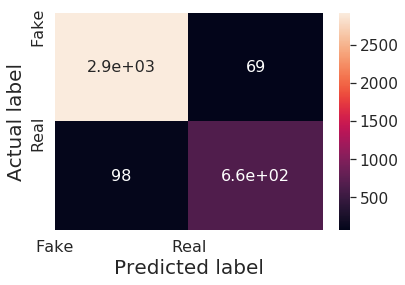

In [76]:
print_confusion_matrix(Y_val_org, model.predict_classes(X))

In [77]:
import sklearn.metrics
cm = sklearn.metrics.accuracy_score(Y_val_org, model.predict_classes(X))
print(cm)

0.9554072096128171
